<a href="https://colab.research.google.com/github/revanth-eranki/dl-notebooks/blob/main/Encoder_Decoder_architechture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np

device_gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import random

In [ ]:
print(device_gpu)
print(torch.cuda.device_count())
print(torch.cuda.get_device_name())

cuda:0
1
Tesla T4


#Data Management




#Alphabets Setup

In [ ]:
eng_alphabets = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
pad_char = '-PAD-'

eng_alpha2index = {pad_char: 0}
for index,alpha in enumerate(eng_alphabets):  # index start from 0
  eng_alpha2index[alpha] = index + 1


print(eng_alpha2index)

{'-PAD-': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26}


In [ ]:
hindi_alphabets = [chr(alpha) for alpha in range(2304,2432)]   # 129 items
hindi_alphabet_size = len(hindi_alphabets)

hindi_alpha2index = {pad_char: 0}
for index,alpha in enumerate(hindi_alphabets):
  hindi_alpha2index[alpha] = index+1

print(hindi_alpha2index)

{'-PAD-': 0, 'ऀ': 1, 'ँ': 2, 'ं': 3, 'ः': 4, 'ऄ': 5, 'अ': 6, 'आ': 7, 'इ': 8, 'ई': 9, 'उ': 10, 'ऊ': 11, 'ऋ': 12, 'ऌ': 13, 'ऍ': 14, 'ऎ': 15, 'ए': 16, 'ऐ': 17, 'ऑ': 18, 'ऒ': 19, 'ओ': 20, 'औ': 21, 'क': 22, 'ख': 23, 'ग': 24, 'घ': 25, 'ङ': 26, 'च': 27, 'छ': 28, 'ज': 29, 'झ': 30, 'ञ': 31, 'ट': 32, 'ठ': 33, 'ड': 34, 'ढ': 35, 'ण': 36, 'त': 37, 'थ': 38, 'द': 39, 'ध': 40, 'न': 41, 'ऩ': 42, 'प': 43, 'फ': 44, 'ब': 45, 'भ': 46, 'म': 47, 'य': 48, 'र': 49, 'ऱ': 50, 'ल': 51, 'ळ': 52, 'ऴ': 53, 'व': 54, 'श': 55, 'ष': 56, 'स': 57, 'ह': 58, 'ऺ': 59, 'ऻ': 60, '़': 61, 'ऽ': 62, 'ा': 63, 'ि': 64, 'ी': 65, 'ु': 66, 'ू': 67, 'ृ': 68, 'ॄ': 69, 'ॅ': 70, 'ॆ': 71, 'े': 72, 'ै': 73, 'ॉ': 74, 'ॊ': 75, 'ो': 76, 'ौ': 77, '्': 78, 'ॎ': 79, 'ॏ': 80, 'ॐ': 81, '॑': 82, '॒': 83, '॓': 84, '॔': 85, 'ॕ': 86, 'ॖ': 87, 'ॗ': 88, 'क़': 89, 'ख़': 90, 'ग़': 91, 'ज़': 92, 'ड़': 93, 'ढ़': 94, 'फ़': 95, 'य़': 96, 'ॠ': 97, 'ॡ': 98, 'ॢ': 99, 'ॣ': 100, '।': 101, '॥': 102, '०': 103, '१': 104, '२': 105, '३': 106, '४': 107, '५': 108, '६': 109, '७': 

#Helper function for data pre-processing

In [ ]:
# The caret ^ at the beginning of the character class negates it, meaning it matches any character not listed within the brackets.
import re

non_eng_letters_regex = re.compile('[^a-zA-Z ]')

# Example string
input_string = "Hello, 123 world!"

# Remove non-English letters and non-space characters
result_string = non_eng_letters_regex.sub('', input_string)

print(result_string)

Hello  world


In [ ]:
import re
non_eng_letters_regex = re.compile('[^a-zA-Z ]')

def cleanEnglishVocab(line):
  line = line.replace('-',' ').replace(',',' ').upper()
  line = non_eng_letters_regex.sub('',line)
  return line.split()

def cleanHindiVocab(line):
  line = line.replace('-',' ').replace(',',' ')
  cleaned_line = ''
  for char in line:
    if char in hindi_alpha2index or char == ' ':
      cleaned_line += char

  return cleaned_line.split()

#Dataset Loading

In [ ]:
from torch.utils.data import Dataset
import xml.etree.ElementTree as ET

class TransliterationDataLoader(Dataset):
    def __init__(self,filename):
        self.eng_words,self.hindi_words = self.readXmlDataset(filename,cleanHindiVocab)
        self.shuffle_indices = list(range(len(self.eng_words)))
        random.shuffle(self.shuffle_indices)
        self.shuffle_start_index = 0

    def __len__(self):
        return len(self.eng_words)

    def __getitem__(self, idx):
        return self.eng_words[idx],self.hindi_words[idx]
    def readXmlDataset(self,filename,lang_vocab_cleaner):
        transliterationCorpus = ET.parse(filename).getroot()
        lang1_words = []
        lang2_words = []

        for line in transliterationCorpus:
          wordlist1 = cleanEnglishVocab(line[0].text)
          wordlist2 = lang_vocab_cleaner(line[1].text)

          # skip noisy data
          if len(wordlist1) != len(wordlist2):
              print('skipping: ',line[0].text,' - ',line[1].text)
              continue

          for word in wordlist1:
              lang1_words.append(word)

          for word in wordlist2:
              lang2_words.append(word)
        return lang1_words,lang2_words

    def get_random_sample(self):
        return self.__getitem__(np.random.randint(len(self.eng_words)))

    def get_batch_from_array(self,batch_size,array):
        end = self.shuffle_start_index + batch_size
        batch =[]
        if end >= len(self.eng_words):
          batch = [array[i] for i in self.shuffle_indices[0:end%len(self.eng_words)]]
          end = len(self.eng_words)
        return batch + [array[i] for i in self.shuffle_indices[self.shuffle_start_index : end]]

    def get_batch(self,batch_size,postprocess = True):
      eng_batch = self.get_batch_from_array(batch_size,self.eng_words)
      hindi_batch = self.get_batch_from_array(batch_size,self.hindi_words)
      self.shuffle_start_index += batch_size + 1

      # reshuffle if 1 epoch is complete
      if self.shuffle_start_index >= len(self.eng_words):
        random.shuffle(self.shuffle_indices)
        self.shuffle_start_index = 0
      return eng_batch,hindi_batch


In [ ]:
train_data = TransliterationDataLoader('NEWS2012-Training-EnHi.xml')
test_data = TransliterationDataLoader('NEWS2012-Ref-EnHi.xml')

skipping:  BARHARWA JUNCTION  -  बरहरवा
skipping:  STATE BNK TR  -  स्टेट बैंक ऑफ त्रावणकोर
skipping:  SOUTH ARLINGTON CHURCH OF CHRIST  -  साउथ अर्लिंग्टन
skipping:  KING EDWARD VII  -  किंग एडवर्ड
skipping:  DIBANG VALLEY  -  दिबंगवैली
skipping:  ORDER OF VASA  -  ऑडर ऑफ़ द वासा
skipping:  AZAMNAGAR ROAD  -  आज़मनगर
skipping:  CAPE TOWN  -  केपटाउन
skipping:  NEW ZEALAND  -  न्यूज़ीलैंड
skipping:  SEA OF THE HEBRIDES  -  सी ऑफ हरब्रिड्‍स
skipping:  RAMCOIND  -  राम्को इंड
skipping:  KELVINGROVE ART GALLERY AND MUSEUM  -  केल्व‍िनग्रोव आर्ट एण्ड म्युज़ियम
skipping:  AUSTRALIAN NATIONAL UNIVERSITY  -  ऑस्ट्रेलियननेशनल यूनिवर्सिटी
skipping:  JAHAN AARA  -  जहाँआरा
skipping:  NAVABHARAT FERRO ALLOYS  -  नव भारत फ़ैरो अलॉय
skipping:  RAMA LINGESHWARA  -  रामालिंगेश्वर
skipping:  FAKHRUN NISA  -  फखरुन्निसा
skipping:  REDIFF.COM INDIA LIMITED  -  रेडिफ़ डॉट कॉम इंडिया लिमिटेड
skipping:  OMKARNATH THAKUR  -  ओंकार नाथ ठाकुर
skipping:  OPENTV  -  ओपन टीवी
skipping:  ENVOY COMMUNICATIONS GROUP  

#Basic data visualisation

In [ ]:
print("train set size: ",len(train_data))
print("tets set size: ",len(test_data))

print("\nsample data from train set: ")
for i in range(5):
  eng,hindi = train_data.get_random_sample()
  print(eng + ' - ' + hindi)

train set size:  20543
tets set size:  1000

sample data from train set: 
WALKER - वॉकर
DALER - दलेर
SOHANI - सोहनी
HYUNDAI - हुंडई
KUMAR - कुमार


#Encoding the words

In [ ]:
def word_rep(word,letter2index,device='cpu'):
  rep = torch.zeros(len(word)+1,1,len(letter2index)).to(device)        # size : len of word x 1 x 27 eng
  for letter_index,letter in enumerate(word):
    pos = letter2index[letter]
    rep[letter_index][0][pos] = 1
  pad_pos = letter2index[pad_char]
  rep[letter_index+1][0][pad_pos] = 1
  return rep

# ground truth (here hindi)
def gt_rep(word,letter2index,device='cpu'):
  gt_rep = torch.zeros([len(word)+1,1],dtype = torch.long).to(device)
  for letter_index,letter in enumerate(word):
    pos = letter2index[letter]
    gt_rep[letter_index][0] = pos
  gt_rep[letter_index+1][0] = letter2index[pad_char]
  return gt_rep


here input size and output size does not match,then we read the entire word at once,then encode this info,process it further then start decoding it

In [ ]:
eng,hindi = train_data.get_random_sample()
eng_rep = word_rep(eng,eng_alpha2index)
print(eng,eng_rep)

OIL tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])


In [ ]:
hindi_gt = gt_rep(hindi,hindi_alpha2index)
print(hindi,hindi_gt)

ऑईल tensor([[18],
        [ 9],
        [51],
        [ 0]])


#Network Architechture

#Encoder-Decoder(using GRU)

input size is 27.hidden size is hyperparamter which can be tuned.output size is 119 here.h2o converts hidden to output size in decoder.it has softmax as it is a classification task

teacher forcing:instead of giving decoders output(softmax) as it is we give the ground truth encoding to decoder input which accelarates training .


In [ ]:
MAX_OUTPUT_CHARS = 30
class Transliteration_EncoderDecoder(nn.Module):

    def __init__(self,input_size,hidden_size,output_size,verbose=False):
      super(Transliteration_EncoderDecoder,self).__init__()

      self.hidden_size = hidden_size
      self.output_size = output_size

      self.encoder_rnn_cell = nn.GRU(input_size,hidden_size)
      self.decoder_rnn_cell = nn.GRU(output_size,hidden_size)

      self.h2o = nn.Linear(hidden_size,output_size)
      self.softmax = nn.LogSoftmax(dim=2)

      self.verbose = verbose

    def forward(self,input,max_output_chars = MAX_OUTPUT_CHARS,device = 'cpu',ground_truth =None):

      # encoder
      out,hidden = self.encoder_rnn_cell(input)

      if self.verbose:
        print('encoder input: ',input.shape)
        print('encoder output: ',out.shape)
        print('encoder hidden: ',hidden.shape)

      # decoder
      decoder_state = hidden
      decoder_input = torch.zeros(1,1,self.output_size).to(device)
      outputs = []

      if self.verbose:
        print('decoder state: ',decoder_state.shape)
        print('decoder input: ',decoder_input.shape)

      for i in range(max_output_chars):

        out,decoder_state = self.decoder_rnn_cell(decoder_input,decoder_state)

        if self.verbose:
          print('decoder intermediate output: ',out.shape)

        out = self.h2o(decoder_state)
        out = self.softmax(out)
        outputs.append(out.view(1,-1))

        if self.verbose:
          print('decoder output : ',out.shape)
          self.verbose = False

        # converting decoder output to one hot encoding
        # so that we can be able to switch the input of next decoder btwn ohe and original ground truth

        max_idx = torch.argmax(out,2,keepdim=True)
        if not ground_truth is None:
          max_idx = ground_truth[i].reshape(1,1,1)
        one_hot = torch.FloatTensor(out.shape).to(device)
        one_hot.zero_()
        one_hot.scatter_(2,max_idx,1)

        decoder_input = one_hot.detach()  # gradients should not be passed through this way

      return outputs

In [ ]:
net1 = Transliteration_EncoderDecoder(len(eng_alpha2index),256,len(hindi_alpha2index),verbose = True)

In [ ]:
print(net1)

Transliteration_EncoderDecoder(
  (encoder_rnn_cell): GRU(27, 256)
  (decoder_rnn_cell): GRU(129, 256)
  (h2o): Linear(in_features=256, out_features=129, bias=True)
  (softmax): LogSoftmax(dim=2)
)


In [ ]:
def infer(net, name,n,device):
  net.eval().to(device)
  name_ohe = word_rep(name,eng_alpha2index,device)
  output = net(name_ohe,n,device)
  return output

In [ ]:
out = infer(net1,'INDIA',30,device="cpu")

encoder input:  torch.Size([6, 1, 27])
encoder output:  torch.Size([6, 1, 256])
encoder hidden:  torch.Size([1, 1, 256])
decoder state:  torch.Size([1, 1, 256])
decoder input:  torch.Size([1, 1, 129])
decoder intermediate output:  torch.Size([1, 1, 256])
decoder output :  torch.Size([1, 1, 129])


In [ ]:
print(len(out))
for i in range(len(out)):
  print(out[i].shape,list(hindi_alpha2index.keys())[list(hindi_alpha2index.values()).index(torch.argmax(out[i]))])

30
torch.Size([1, 129]) स
torch.Size([1, 129]) स
torch.Size([1, 129]) स
torch.Size([1, 129]) स
torch.Size([1, 129]) स
torch.Size([1, 129]) स
torch.Size([1, 129]) ँ
torch.Size([1, 129]) ँ
torch.Size([1, 129]) ँ
torch.Size([1, 129]) ँ
torch.Size([1, 129]) फ़
torch.Size([1, 129]) ड़
torch.Size([1, 129]) स
torch.Size([1, 129]) स
torch.Size([1, 129]) स
torch.Size([1, 129]) ँ
torch.Size([1, 129]) ँ
torch.Size([1, 129]) ँ
torch.Size([1, 129]) ँ
torch.Size([1, 129]) फ़
torch.Size([1, 129]) ड़
torch.Size([1, 129]) स
torch.Size([1, 129]) स
torch.Size([1, 129]) स
torch.Size([1, 129]) ँ
torch.Size([1, 129]) ँ
torch.Size([1, 129]) ँ
torch.Size([1, 129]) ँ
torch.Size([1, 129]) फ़
torch.Size([1, 129]) ड़


#with Attention

In [ ]:
MAX_OUTPUT_CHARS = 30
class Transliteration_EncoderDecoder_Attention(nn.Module):

    def __init__(self,input_size,hidden_size,output_size,verbose=False):
      super(Transliteration_EncoderDecoder_Attention,self).__init__()

      self.hidden_size = hidden_size
      self.output_size = output_size

      self.encoder_rnn_cell = nn.GRU(input_size,hidden_size)
      self.decoder_rnn_cell = nn.GRU(hidden_size*2,hidden_size)

      self.h2o = nn.Linear(hidden_size,output_size)
      self.softmax = nn.LogSoftmax(dim=2)

      self.U = nn.Linear(self.hidden_size,self.hidden_size)
      self.W = nn.Linear(self.hidden_size,self.hidden_size)
      self.attn = nn.Linear(self.hidden_size,1)
      self.out2hidden = nn.Linear(self.output_size,self.hidden_size)

      self.verbose = verbose

    def forward(self,input,max_output_chars = MAX_OUTPUT_CHARS,device = 'cpu',ground_truth =None):

      # encoder
      eout,hidden = self.encoder_rnn_cell(input)
      eout = eout.view(-1,self.hidden_size)

      if self.verbose:
        print('encoder output: ',eout.shape)

      # decoder
      decoder_state = hidden
      decoder_input = torch.zeros(1,1,self.output_size).to(device)
      outputs = []
      U = self.U(eout)

      if self.verbose:
        print('decoder state: ',decoder_state.shape)
        print('decoder intermediate input: ',decoder_input.shape)
        print('U * encoder output ',U.shape)

      for i in range(max_output_chars):
        W = self.W(decoder_state.view(1,-1).repeat(eout.shape[0],1))
        V = self.attn(torch.tanh(U + W))
        attn_weights = F.softmax(V.view(1,-1),dim = 1)

        """ if self.verbose:
          print('w * decoder state ',W.shape)
          print('V ',V.shape)
          print('attn ',attn_weights.shape)

          print('attn_weights shape:', attn_weights.unsqueeze(0).shape)
          print('out shape:', out.unsqueeze(0).shape)"""
        attn_applied =  torch.bmm(attn_weights.unsqueeze(0),eout.unsqueeze(0))
        embedding = self.out2hidden(decoder_input)
        decoder_input = torch.cat((embedding[0],attn_applied[0]),1).unsqueeze(0)

        """if self.verbose:
          print('attn lc',attn_applied.shape)
          print('decoder input',decoder_input.shape)"""


        out,decoder_state = self.decoder_rnn_cell(decoder_input,decoder_state)
        """ if self.verbose:
          print('decoder intermediate output: ',out.shape)"""

        out = self.h2o(decoder_state)
        out = self.softmax(out)
        outputs.append(out.view(1,-1))

        """ if self.verbose:
          print('decoder output : ',out.shape)
          self.verbose = False

        # converting decoder output to one hot encoding
        # so that we can be able to switch the input of next decoder btwn ohe and original ground truth
        """
        max_idx = torch.argmax(out,2,keepdim=True)
        if not ground_truth is None:
          max_idx = ground_truth[i].reshape(1,1,1)
        one_hot = torch.zeros(out.shape,device = device)
        one_hot.scatter_(2,max_idx,1)

        decoder_input = one_hot.detach()  # gradients should not be passed through this way

      return outputs

In [ ]:
net = Transliteration_EncoderDecoder_Attention(len(eng_alpha2index),256,len(hindi_alpha2index),verbose = False)

In [ ]:
out = infer(net_att,'REVANTH',30,'cuda:0')


In [ ]:
for i in range(len(out)):
    # Get the index with the maximum value in the tensor
    max_index = torch.argmax(out[i]).item()

    # Find the corresponding character using the dictionary
    corresponding_char = list(hindi_alpha2index.keys())[list(hindi_alpha2index.values()).index(max_index)]

    # Check if the character is '-PAD-'
    if corresponding_char == '-PAD-':
        break  # Stop the loop if '-PAD-' is encountered

    # Print the character
    print(corresponding_char)


र
े
व
ा
थ


#Training

#Core trainer

In [ ]:
def train_batch(net, opt, criterion, batch_size, device = 'cpu', teacherforce = False):

  net.train().to(device)
  opt.zero_grad()
  eng_batch, hindi_batch = train_data.get_batch(batch_size)

  total_loss = 0
  for i in range(batch_size):
    input = word_rep(eng_batch[i],eng_alpha2index, device)
    gt = gt_rep(hindi_batch[i],hindi_alpha2index, device)
    outputs = net(input, gt.shape[0], device, ground_truth = gt if teacherforce else None)

    for index, output in enumerate(outputs):
      loss = criterion(output, gt[index]) / batch_size
      loss.backward(retain_graph = True)
      total_loss += loss
  opt.step()
  return total_loss/batch_size

#training helper

In [ ]:
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, display_freq = 5, device = 'cpu'):

  net = net.to(device)
  criterion = nn.NLLLoss(ignore_index = -1)
  opt = optim.Adam(net.parameters(), lr=lr)
  teacher_force_upto = n_batches//3

  loss_arr = np.zeros(n_batches+1)

  for i in range(n_batches):
    loss_arr[i+1] = (loss_arr[i]*i + train_batch(net, opt, criterion, batch_size, device = device, teacherforce = i<teacher_force_upto)) /(i+1)
    if i%display_freq == display_freq-1:
        clear_output(wait=True)
        print('Iteration', i, 'Loss', loss_arr[i])
        plt.figure()
        plt.plot(loss_arr[1:i], '-*')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.show()
        print('\n\n')

  return loss_arr

#training without attention

Iteration 199 Loss 0.32891932129859924


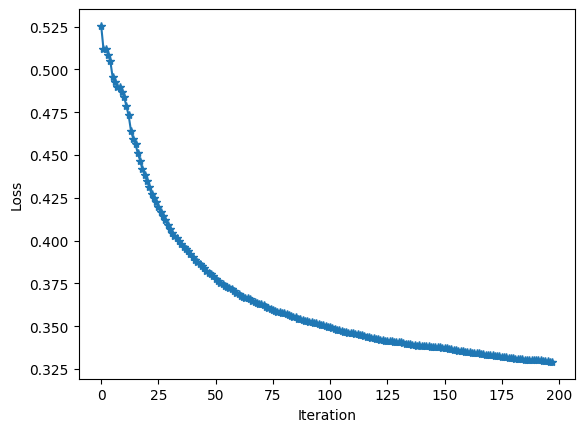

array([0.        , 0.52543318, 0.51191938, 0.51215398, 0.50870728,
       0.50469911, 0.49550733, 0.4926607 , 0.4897137 , 0.48951352,
       0.48706609, 0.48407418, 0.478659  , 0.4731209 , 0.46418566,
       0.45961651, 0.45627141, 0.45099661, 0.44675127, 0.4416897 ,
       0.43843991, 0.43488052, 0.4311752 , 0.42731801, 0.42503721,
       0.42233321, 0.41936237, 0.41701525, 0.41443071, 0.41197515,
       0.40939754, 0.40686855, 0.4044669 , 0.40276757, 0.40144345,
       0.39982969, 0.39782602, 0.39613429, 0.39521274, 0.39382794,
       0.39229646, 0.39037707, 0.38888785, 0.38759512, 0.38639945,
       0.38527328, 0.38405097, 0.38241714, 0.38130462, 0.3802906 ,
       0.37916794, 0.37785369, 0.37664652, 0.37533653, 0.37449667,
       0.37357861, 0.37291473, 0.37238073, 0.37150726, 0.3703883 ,
       0.36960423, 0.36881664, 0.36788526, 0.3672401 , 0.36662254,
       0.36623201, 0.36566445, 0.36470935, 0.36410835, 0.36352861,
       0.3631112 , 0.36270311, 0.36214185, 0.36136052, 0.36070

In [ ]:
net = Transliteration_EncoderDecoder(len(eng_alpha2index),256,len(hindi_alpha2index))
train_setup(net, lr=0.001, n_batches = 200, batch_size = 64, display_freq=10, device= device_gpu)

#training with attention

Iteration 799 Loss 0.23626916110515594


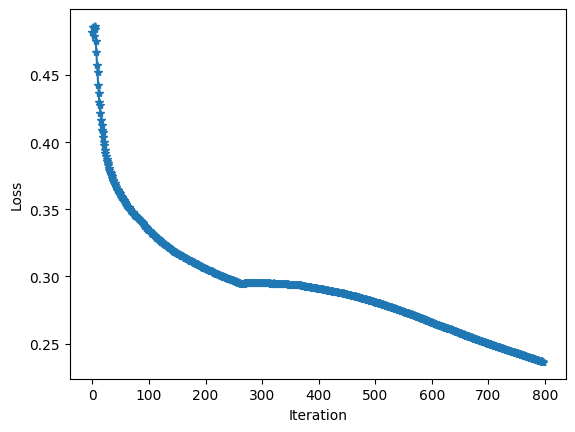

In [ ]:
net_att = Transliteration_EncoderDecoder_Attention(len(eng_alpha2index),256,len(hindi_alpha2index))
loss_history = train_setup(net_att, lr=0.001, n_batches = 800, batch_size = 64, display_freq=40, device= device_gpu)

In [ ]:
def calc_accuracy(net, device = 'cpu'):
  net = net.eval().to(device)
  predictions = []
  accuracy = 0
  for i in range(len(test_data)):
    eng,hindi = test_data[i]
    gt = gt_rep(hindi,hindi_alpha2index, device)
    outputs = infer(net,eng,gt.shape[0], device)
    correct = 0
    for index,out in enumerate(outputs):
      val, indices = out.topk(1)
      hindi_pos = indices.tolist()[0]
      if hindi_pos[0] == gt[index][0]:
        correct += 1
    accuracy += correct/gt.shape[0]
  accuracy /= len(test_data)
  return accuracy

In [ ]:
accuracy = calc_accuracy(net_att,'cuda:0') * 100
print(accuracy)

60.63156066156068
